# BCHPCA Financial Analysis&Outlook

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

The stakeholder did not have their own data to analyze and answer questions. The data was sourced from Canada Revenue Agency, BC Stats and Statistics Canada. Data verifying, merging, and engineering of new variables were performed using Excel.

## 1. Data Description

Hospice General Information:
* Year - fiscal year when CRA report was generated.
* Region - regional health territory where the hospice is registered and operating.
* Type - C (Community based) and R (Residential – hospital based).
* City - nearest urban area where hospice is operating the pallative services.
* Population - population is based on a per city population sourced from BC Stats. However, due to unavailability of some city data on a per year, some city population were derived from the yearly regional population and further reduced to city-size by basing it on the 2016 city statitics sourced from Wikipedia.

Population derivative formula (for cities with no population data):
* Total Population = City population 2016 + City population % change from 2016 (based on yearly regional population change).
* Elderly population from 65+ = population share of 65+ elderly population (based on yearly regional BC Stats) x  Total Population.


Hospices Revenue includes the following sources:

* Govt Funding - these are funds sourced from the federal government.
* Donations - these are donated funds to hospices regardless receipted or non-receipted.
* Others - these are gifts from other charities and revenue from fund raising.

Hospices Expenses are broken down as follows:

* Charitable Expenditures
* Management & Administration
* Fund Raising
* Political Activities
* Gifts to other registered charities
* Other

## 2. Data Preparation
### 2.1 Importing the Data

In [2]:
# loading the dataset and exploring initial view of the data
# Each hospice in the dataset includes revenue and expenses records per year
# Converting the Year column into datetime format for analysis in pandas
df = pd.read_excel('CRA_DATA.xlsx')
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year
df.head(5)

,Hospice Name,Year,Region,City,Population total,65_over,Type Of Hospice,Donations,Others,Govt Funding,...,FULL - TIME STAFF,PART - TIME STAFF,PRICE_BC_HEALTH,PRICE_BC_SERVICES,PRICE_BC_GOODS,PRICE_CA_HEALTH,PRICE_CA_SERVICES,PRICE_CA_GOODS,TOTAL REVENUE,TOTAL EXPENDITURE
0,100 Mile District Hospice Palliative Care Society,2021,Interior Health,100 MILE HOUSE,15109.0,4509.0,C,116674,73450,43786,...,0,3,127.950000,142.020000,128.370000,132.310000,154.420000,127.700000,233910,189139
1,100 Mile District Hospice Palliative Care Society,2020,Interior Health,100 MILE HOUSE,15119.0,4260.0,C,38222,1352,38487,...,0,3,124.850000,139.800000,123.491667,129.200000,151.341667,122.450000,78061,76291
2,100 Mile District Hospice Palliative Care Society,2019,Interior Health,100 MILE HOUSE,14971.0,3998.0,C,28088,16939,33322,...,0,3,121.725000,138.125000,123.341667,127.366667,149.200000,122.650000,78349,61739
3,100 Mile District Hospice Palliative Care Society,2018,Interior Health,100 MILE HOUSE,14911.0,3901.0,C,24326,5664,32706,...,0,3,119.650000,135.108333,120.516667,125.941667,145.758333,121.058333,62696,58263
4,100 Mile District Hospice Palliative Care Society,2017,Interior Health,100 MILE HOUSE,14932.0,3801.0,C,3850,2010,0,...,0,3,118.083333,130.900000,118.125000,124.250000,142.000000,118.916667,5860,5367


### 2.2 Data Formatting and Cleaning

In [3]:
#Renaming some columns in the dataframe to shorten the labels and for ease
df = df.rename(columns={'Hospice Name':'Hospice', 'Others':'Other_rev', 'Other':'Other_ex', 'Govt Funding':'Govt_Funding', 'Charitable Expenditures':'Charitable_Ex', 'Management & Administration':'Management_Admin', 'Fund Raising':'Fund_Raising', 'Political Activities':'Political_Activities', 'Gifts to other registered charities':'Gifts_to_others', 'Professional & Consulting':'Professional_Consulting', 'FULL - TIME STAFF':'Full_Time_Staff', 'PART - TIME STAFF':'Part_time_Staff'})
df.head(3)

,Hospice,Year,Region,City,Population total,65_over,Type Of Hospice,Donations,Other_rev,Govt_Funding,...,Full_Time_Staff,Part_time_Staff,PRICE_BC_HEALTH,PRICE_BC_SERVICES,PRICE_BC_GOODS,PRICE_CA_HEALTH,PRICE_CA_SERVICES,PRICE_CA_GOODS,TOTAL REVENUE,TOTAL EXPENDITURE
0,100 Mile District Hospice Palliative Care Society,2021,Interior Health,100 MILE HOUSE,15109.0,4509.0,C,116674,73450,43786,...,0,3,127.950,142.020,128.370000,132.310000,154.420000,127.70,233910,189139
1,100 Mile District Hospice Palliative Care Society,2020,Interior Health,100 MILE HOUSE,15119.0,4260.0,C,38222,1352,38487,...,0,3,124.850,139.800,123.491667,129.200000,151.341667,122.45,78061,76291
2,100 Mile District Hospice Palliative Care Society,2019,Interior Health,100 MILE HOUSE,14971.0,3998.0,C,28088,16939,33322,...,0,3,121.725,138.125,123.341667,127.366667,149.200000,122.65,78349,61739


In [4]:
# This is to count unique total hospices in the dataset based on names

total_hospices = len(df[['Hospice']].drop_duplicates())
print ('Total Hospices: '  + str(total_hospices))

Total Hospices: 70


In [5]:
# Filter out USA hospices as they are not part of BCHPCA

df = df[df['Region'] != 'USA']

In [6]:
#Nan values are just missing values in the dataset which indicates zero amount.
#Zero amount or missing values is just indicator of no revenue or no expenditure and will have no impact in the computation
count_nan = df.isna().sum().sum()
print ('Count of NaN: ' + str(count_nan))

Count of NaN: 50


In [7]:
num = 0
for i in df.columns:
   num += df[i][df[i]==0].count()
print ('Count of Zero: ' + str(num))

Count of Zero: 1804


In [8]:
# This is to count available yearly records across hospices

Hospice_Yr = df[['Hospice','Year']]
Hospice_Yr_Cnt = Hospice_Yr.groupby('Year').agg(['count']).stack()
Hospice_Yr_Cnt

,,Hospice
Year,,
2015,count,3
2016,count,35
2017,count,68
2018,count,70
2019,count,70
2020,count,67
2021,count,34


In [9]:
# Year data is not consistent across all hospices
# In 2015,2016 and 2021 there are 3, 35 & 33 only, hospices reports, respectively.
# To ensure robustness of the data analysis,years that are not well represented will be filtered out from the dataset.
df_4yrs = df[(df['Year'] > 2016) & (df['Year'] < 2021)]
df_4yrs.head(4)

,Hospice,Year,Region,City,Population total,65_over,Type Of Hospice,Donations,Other_rev,Govt_Funding,...,Full_Time_Staff,Part_time_Staff,PRICE_BC_HEALTH,PRICE_BC_SERVICES,PRICE_BC_GOODS,PRICE_CA_HEALTH,PRICE_CA_SERVICES,PRICE_CA_GOODS,TOTAL REVENUE,TOTAL EXPENDITURE
1,100 Mile District Hospice Palliative Care Society,2020,Interior Health,100 MILE HOUSE,15119.0,4260.0,C,38222,1352,38487,...,0,3,124.850000,139.800000,123.491667,129.200000,151.341667,122.450000,78061,76291
2,100 Mile District Hospice Palliative Care Society,2019,Interior Health,100 MILE HOUSE,14971.0,3998.0,C,28088,16939,33322,...,0,3,121.725000,138.125000,123.341667,127.366667,149.200000,122.650000,78349,61739
3,100 Mile District Hospice Palliative Care Society,2018,Interior Health,100 MILE HOUSE,14911.0,3901.0,C,24326,5664,32706,...,0,3,119.650000,135.108333,120.516667,125.941667,145.758333,121.058333,62696,58263
4,100 Mile District Hospice Palliative Care Society,2017,Interior Health,100 MILE HOUSE,14932.0,3801.0,C,3850,2010,0,...,0,3,118.083333,130.900000,118.125000,124.250000,142.000000,118.916667,5860,5367


## 3. Analyze BCHPCA Revenue Trend

In [10]:
# Creating dataframe containing revenue per hospice per type

Hospice_Rev = df_4yrs[['Hospice','Year','Region','Donations','Other_rev','Govt_Funding']]
Hospice_Rev

,Hospice,Year,Region,Donations,Other_rev,Govt_Funding
1,100 Mile District Hospice Palliative Care Society,2020,Interior Health,38222,1352,38487
2,100 Mile District Hospice Palliative Care Society,2019,Interior Health,28088,16939,33322
3,100 Mile District Hospice Palliative Care Society,2018,Interior Health,24326,5664,32706
4,100 Mile District Hospice Palliative Care Society,2017,Interior Health,3850,2010,0
6,Abbotsford Hospice Society,2020,Fraser Health,726276,185015,538603
...,...,...,...,...,...,...
340,Hospice Society of Victoria County,2017,Island Health,10789,334,0
343,Williams Lake Hospice Society,2020,Interior Health,31018,1074,124391
344,Williams Lake Hospice Society,2019,Interior Health,17991,9979,91817
345,Williams Lake Hospice Society,2018,Interior Health,26930,8234,76900


In [11]:
# Creating dataframe for the yearly trend of hospice revenue and plotting

Hospice_govshare = Hospice_Rev.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()
Hospice_govshare

<ipython-input-11-1101803b42ca>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_govshare = Hospice_Rev.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()


,Year,Govt_Funding,Donations,Other_rev
0,2017,21151080,24436752,12942508
1,2018,22204506,22118158,13422434
2,2019,24330679,27353310,20629639
3,2020,22883324,23729016,21099165


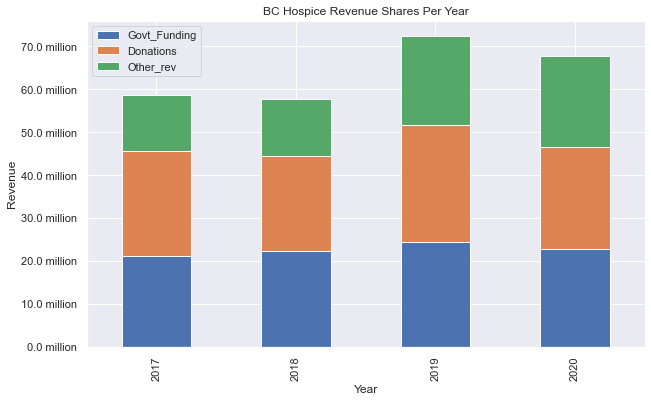

In [12]:
ax = Hospice_govshare.set_index('Year').plot(kind="bar", stacked=True,figsize=(10,6))
plt.title("BC Hospice Revenue Shares Per Year")
plt.xlabel("Year")
plt.ylabel("Revenue")

def formatter(x, pos):
    return str(round(x / 1e6, 1)) + " million"

ax.yaxis.set_major_formatter(formatter)

In [13]:
# Creating dataframe for the yearly trend in shares of hospice revenue and plotting

Hospice_Trend_Yr = Hospice_Rev.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum()
Hospice_Trend_Yr

<ipython-input-13-df1762f12d99>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_Trend_Yr = Hospice_Rev.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum()


,Govt_Funding,Donations,Other_rev
Year,,,
2017,21151080,24436752,12942508
2018,22204506,22118158,13422434
2019,24330679,27353310,20629639
2020,22883324,23729016,21099165


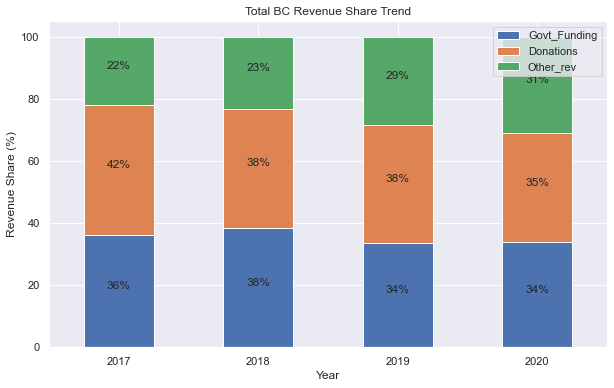

In [14]:
ax = Hospice_Trend_Yr.apply(lambda x: x*100/sum(x), axis=1)
ax_1 = ax.plot.bar(figsize=(10,6), stacked=True, rot=0)
plt.title("Total BC Revenue Share Trend")
plt.xlabel("Year")
plt.ylabel("Revenue Share (%)")

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')

Total BC Hospice Revenue average growth is 5.8% in 4 years from 2017-2020. This is driven by growth from Other Revenue sources which comes from gifts and fundraising activities. This increase is a sharp change from 2017-2018, when the average Other Revenue was only 13 million, and during COVID 2019-2020, the average has already risen to 21 million, despite the situation with the pandemic.

Donations used to be a big share of the total revenue in 2017; however, in 4 years, shares have shifted to Other Revenue coming from a 22% share into 31% share in 2020.

Let’s look at the revenue source with a stable growth trend, ’Other revenue’, in details. This revenue was derived from the summation of revenue from fundraising and gifts from other charities. The analysis of fundraising and gifts dynamics was performed in excel with initial data.



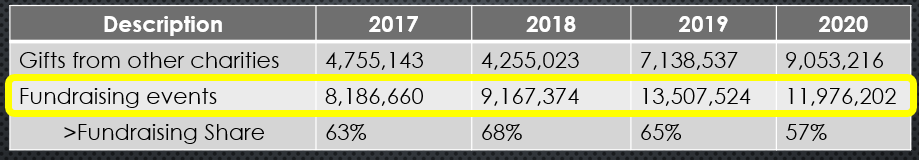

The share of fundraising revenue was 65% in Other revenue source until 2019 and dropped to 57% in 2020.

## 4. Analysis of Revenue Trends per Health Region and Hospice Type
### 4.1 Revenue Trend by Health Region

In [15]:
# Creating dataframe for the yearly revenue trend per health region 

Hospice_Trend_Reg = Hospice_Rev.groupby(['Region','Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()
Fraser_Health = Hospice_Trend_Reg.loc[Hospice_Trend_Reg['Region']=='Fraser Health']
Interior_Health = Hospice_Trend_Reg.loc[Hospice_Trend_Reg['Region']=='Interior Health']
Island_Health = Hospice_Trend_Reg.loc[Hospice_Trend_Reg['Region']=='Island Health']
Northern_Health = Hospice_Trend_Reg.loc[Hospice_Trend_Reg['Region']=='Northern Health']
Vancouver_Coastal_Health = Hospice_Trend_Reg.loc[Hospice_Trend_Reg['Region']=='Vancouver Coastal Health']

<ipython-input-15-60897bdcc4cd>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_Trend_Reg = Hospice_Rev.groupby(['Region','Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()


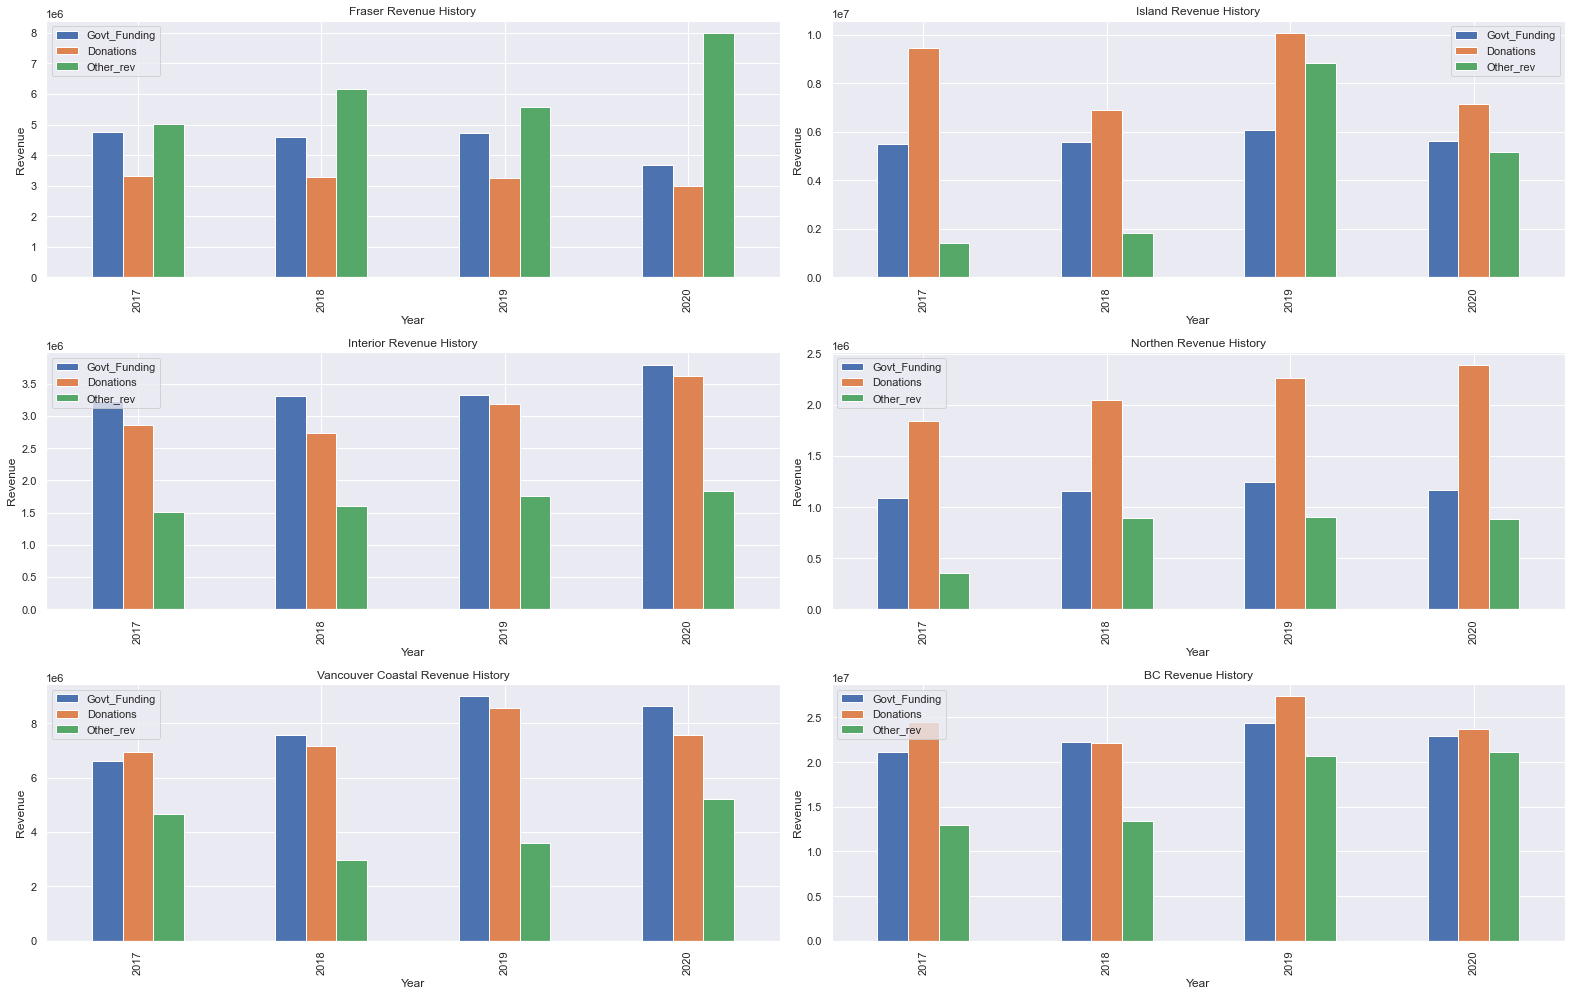

In [16]:
# Creating a dashboard comparing 5 regions revenue; BC revenue trend is also included 

fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3,ncols=2,figsize=(22,14))
ax1=Fraser_Health.set_index('Year').plot(kind="bar",ax=ax1)
ax1.set_title('Fraser Revenue History')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue')
ax2=Island_Health.set_index('Year').plot(kind="bar",ax=ax2)
ax2.set_title('Island Revenue History')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue')
ax3=Interior_Health.set_index('Year').plot(kind="bar",ax=ax3)
ax3.set_title('Interior Revenue History')
ax3.set_xlabel('Year')
ax3.set_ylabel('Revenue')
ax4=Northern_Health.set_index('Year').plot(kind="bar",ax=ax4)
ax4.set_title('Northen Revenue History')
ax4.set_xlabel('Year')
ax4.set_ylabel('Revenue')
ax5=Vancouver_Coastal_Health.set_index('Year').plot(kind="bar",ax=ax5)
ax5.set_title('Vancouver Coastal Revenue History')
ax5.set_xlabel('Year')
ax5.set_ylabel('Revenue')
ax6=Hospice_govshare.set_index('Year').plot(kind="bar",ax=ax6)
ax6.set_title('BC Revenue History')
ax6.set_xlabel('Year')
ax6.set_ylabel('Revenue')

plt.tight_layout()

Within Other Revenue, growth drivers are namely, Island Health, Vancouver, and Fraser Health.

Island and Northern Health are very dependent on donations as this is the largest portion of their income in the first place, and thus may be forced to depend on Government Funding or Other Revenue to maintain their regular operations.

### 4.2 Revenue Trend by Hospice Type

In [17]:
# Creating dataframe for revenue by hocpice type

df_com = df_4yrs[df_4yrs['Type Of Hospice'] == 'C']
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 1 to 346
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospice                  239 non-null    object        
 1   Year                     239 non-null    int64         
 2   Region                   239 non-null    object        
 3   City                     239 non-null    object        
 4   Population total         239 non-null    float64       
 5   65_over                  239 non-null    float64       
 6   Type Of Hospice          239 non-null    object        
 7   Donations                239 non-null    int64         
 8   Other_rev                239 non-null    int64         
 9   Govt_Funding             239 non-null    int64         
 10  Date                     239 non-null    datetime64[ns]
 11  Charitable_Ex            239 non-null    int64         
 12  Management_Admin         239 non-nul

In [18]:
df_res = df_4yrs[df_4yrs['Type Of Hospice'] == 'R']

There are 239 rows for Community hospices and 107 rows for Residential hospices.

In [19]:
# Creating dataframes for the yearly revenue trend per hospice type
# Community type
Hospice_Rev_com = df_com[['Hospice','Year','Region','Donations','Other_rev','Govt_Funding']]
Hospice_govshare_com = Hospice_Rev_com.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()

# Residential type
Hospice_Rev_res = df_res[['Hospice','Year','Region','Donations','Other_rev','Govt_Funding']]
Hospice_govshare_res = Hospice_Rev_res.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()

<ipython-input-19-2e543839c396>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_govshare_com = Hospice_Rev_com.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()
<ipython-input-19-2e543839c396>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_govshare_res = Hospice_Rev_res.groupby(['Year'])['Govt_Funding','Donations','Other_rev'].sum().reset_index()


Text(0, 0.5, 'Revenue')

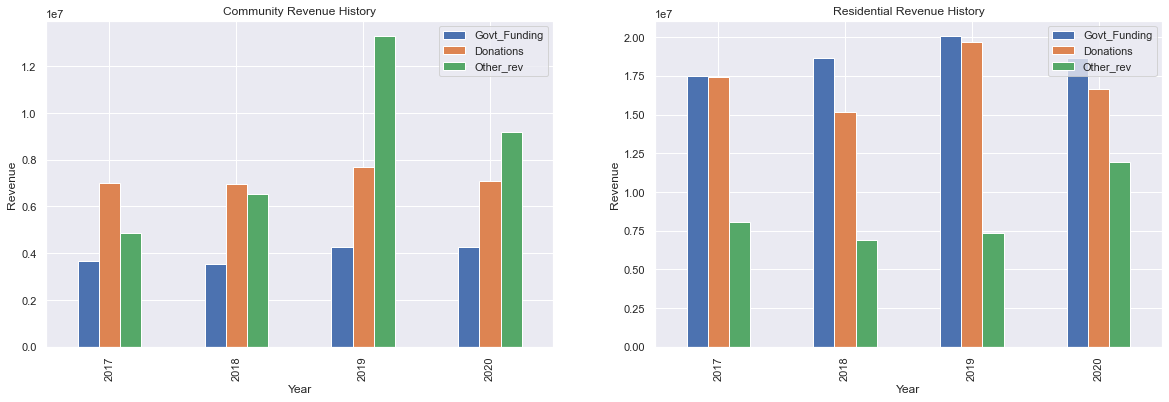

In [20]:
# Compare revenue trends for community and residential hospices

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax1=Hospice_govshare_com.set_index('Year').plot(kind="bar",ax=ax1)
ax1.set_title('Community Revenue History')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue')
ax2=Hospice_govshare_res.set_index('Year').plot(kind="bar",ax=ax2)
ax2.set_title('Residential Revenue History')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue')

Residential hospices are less than the number of community hospices but receive much more government funding compared to community hospices, which rely primarily on other income and donations. Indeed, Residential hospices are expected to have higher medical and living expenses compared to home services provided by community hospices. However, the stakeholder stated that the current distribution is unfair in terms of the growing number of specialized services needed in communities.

When asked about the main impact on growth in services, the stakeholder reported that this is the population over 65 years of age. Let's look at the shares of Government Funding and 65+population by hospice type. 

In [21]:
# Creating dataframe for the shares of Gov_Funding by hospice type
df1 = df_4yrs.groupby(['Year','Type Of Hospice'])['Govt_Funding'].sum().unstack()
df1

Type Of Hospice,C,R
Year,,
2017,3655273,17495807
2018,3529472,18675034
2019,4271016,20059663
2020,4247722,18635602


In [22]:
Data = {'year': [2017,2018,2019,2020],
        'Com': [3655273,3529472,4271016,4247722],
        'Res':[17495807,18675034,20059663,18635602]
       }
Com_Res_Gov = pd.DataFrame(Data,columns=['year','Com','Res'])

# Creating dataframe for the shares of 65+population by hospice type
df2 = df_4yrs.groupby(['Year','Type Of Hospice'])['65_over'].sum().unstack()
Data2 = {'year': [2017,2018,2019,2020],
        'Com': [379584,437506,458610,477115],
        'Res':[237675,248678,260603,272890]
       }
Com_Res_65 = pd.DataFrame(Data2,columns=['year','Com','Res'])

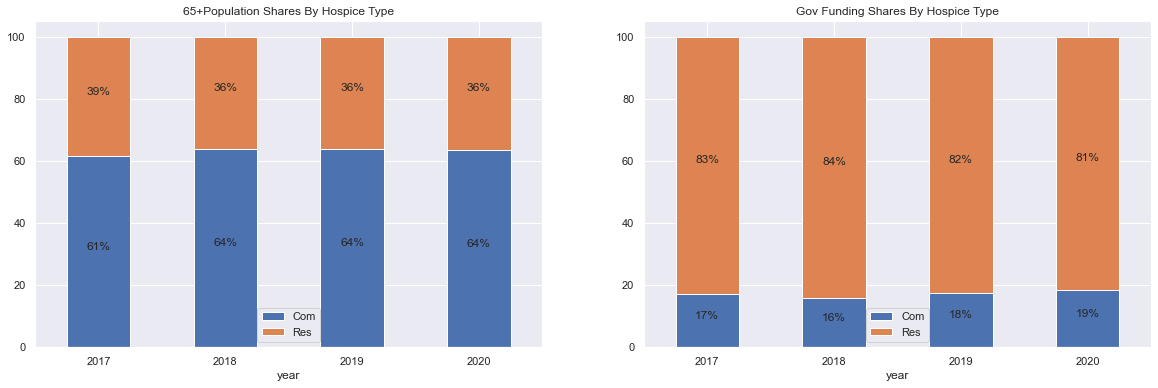

In [23]:
# Comparison of shares of government funding with the shares of the 65+ population by type of hospice

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

ax1 = (Com_Res_65.set_index('year').apply(lambda x: x*100/sum(x), axis=1)).plot.bar(stacked=True, rot=0,ax=ax1)
for rec in ax1.patches:
    height = rec.get_height()
    ax1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
ax1.set_title('65+Population Shares By Hospice Type')

ax2=(Com_Res_Gov.set_index('year').apply(lambda x: x*100/sum(x), axis=1)).plot.bar(stacked=True, rot=0,ax=ax2)
for rec in ax2.patches:
    height = rec.get_height()
    ax2.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom')
ax2.set_title('Gov Funding Shares By Hospice Type');

Community types in general have very little funding with a 19% share of government funding last year 2020 alone, but they have broader coverage of 65+ population, accounting for 64% of BC's total older population, while residential type, which has the largest share of government funding at 81%, serves only 36% of the 65+ population.

The residential hospices are expected to serve the 65+ population covered by community hospices who need constant medical care. However, this assumption could not be tested because the stakeholder did not have data on the annual 65+population served by residential hospices.

## 5. Analysis of Services Expenditures Trend

Charitable Expenses is closely associated to hospices services and can reflect the volume of services provided by hospices (based on description in Canada Revenue Agency). Since the stakeholder did not have data on the volume of services provided annually in the BC, it was decided to consider Charitable Expenses as an indicator of the dynamics of services and compare it with the dynamics of Government Funding.

In [24]:
# Creating a dataframe for the yearly service expenditures trend

Hospice_Ex = df_4yrs[['Year','Charitable_Ex','Management_Admin','Fund_Raising','Political_Activities','Gifts_to_others','Other_ex']]
Hospice_Ex_Yr=Hospice_Ex.groupby(['Year'])['Charitable_Ex','Management_Admin','Fund_Raising','Political_Activities','Gifts_to_others','Other_ex'].sum().reset_index()
Hospice_Ex_Yr

<ipython-input-24-4cf9fbb680b0>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Hospice_Ex_Yr=Hospice_Ex.groupby(['Year'])['Charitable_Ex','Management_Admin','Fund_Raising','Political_Activities','Gifts_to_others','Other_ex'].sum().reset_index()


,Year,Charitable_Ex,Management_Admin,Fund_Raising,Political_Activities,Gifts_to_others,Other_ex
0,2017,25792049,7543069,5818319,0.0,5423805.0,8202907.0
1,2018,34532046,7205819,6905526,0.0,2645244.0,1688528.0
2,2019,36137869,7643470,7669409,0.0,3676452.0,1861407.0
3,2020,39750274,8092625,7358172,286232.0,6350690.0,1067417.0


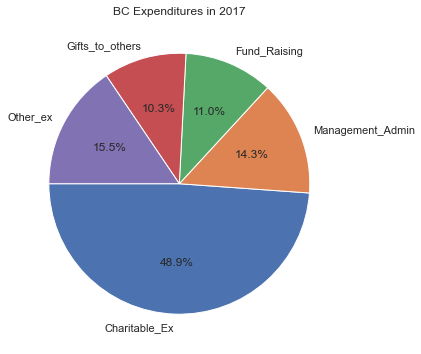

In [25]:
# Structure of total expenses of hospices in 2017 

data = [25792049, 7543069, 5818319, 5423805, 8202907]
labels =['Charitable_Ex','Management_Admin','Fund_Raising','Gifts_to_others','Other_ex']
plt.figure(figsize=(12,6))
plt.title('BC Expenditures in 2017' )
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=180);

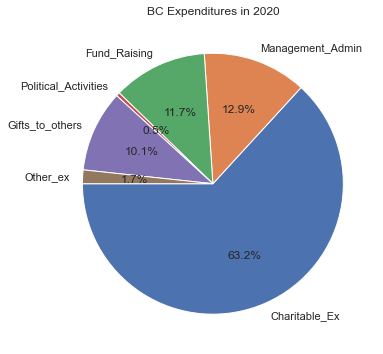

In [26]:
# Structure of total expenses of hospices in 2020 

data1 = [39750274, 8092625, 7358172,286232, 6350690, 1067417]
labels1 =['Charitable_Ex','Management_Admin','Fund_Raising','Political_Activities','Gifts_to_others','Other_ex']
plt.figure(figsize=(12,6))
plt.title('BC Expenditures in 2020' )
plt.pie(data1, labels=labels1, autopct='%1.1f%%', startangle=180);

Charitable Expenses is the major chunk of the total expenses. It is also a growing expense type across BC hospices increasing from 49% of total expenses in 2017 to 63% in 2020. 

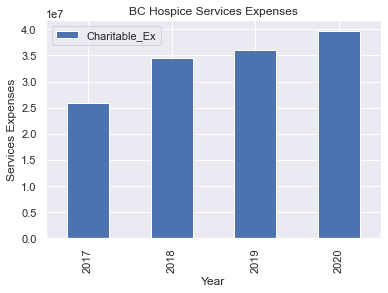

In [27]:
# Let's look at dynamic of Charitable Expenses

Charitable_Ex_Yr=Hospice_Ex.groupby(['Year'])['Charitable_Ex'].sum().reset_index()
Charitable_Ex_Yr.set_index('Year').plot(kind="bar")
plt.title("BC Hospice Services Expenses")
plt.xlabel("Year")
plt.ylabel("Services Expenses");

In [28]:
# Comparison of Charitable Expenses dynamic and Gov Funding dynamic

Ex_and_Govfund = df_4yrs[['Year','Charitable_Ex','Govt_Funding']]
Ex_and_Govfund_Yr=Ex_and_Govfund.groupby(['Year'])['Charitable_Ex','Govt_Funding'].sum().reset_index()
Ex_and_Govfund_Yr

<ipython-input-28-ea84b08e9ed1>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Ex_and_Govfund_Yr=Ex_and_Govfund.groupby(['Year'])['Charitable_Ex','Govt_Funding'].sum().reset_index()


,Year,Charitable_Ex,Govt_Funding
0,2017,25792049,21151080
1,2018,34532046,22204506
2,2019,36137869,24330679
3,2020,39750274,22883324


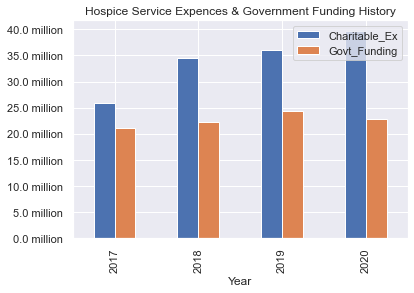

In [29]:
ax = Ex_and_Govfund_Yr.set_index('Year').plot(kind="bar")
plt.title("Hospice Service Expences & Government Funding History")
plt.xlabel("Year")

def formatter(x, pos):
    return str(round(x / 1e6, 1)) + " million"

ax.yaxis.set_major_formatter(formatter)

In [30]:
Ex_and_Govfund_Yr_pc=Ex_and_Govfund_Yr.set_index('Year')[['Charitable_Ex','Govt_Funding']].pct_change()*100
print(Ex_and_Govfund_Yr_pc[['Charitable_Ex','Govt_Funding']].mean())

Charitable_Ex    16.177605
Govt_Funding      2.869071
dtype: float64


Charitable Expenses grew by 16% avg yearly. Since the growth of Government funding, averaging 2.9% per year, is not as fast as   the growth of Charitable expenses, this means that growth in services is sustained by other sources of revenue.

Charitable expenses, as mentioned above, is closely related to hospice services, not to mention its sheer size, so it's a good variable to predict future budget needs.

## 6.	Cross-reference with BC Stats 

In [31]:
# Creating dataframes for yearly trend analysis

# 65+population by year
seniors = df_4yrs[['Year','65_over']]
seniors_Yr=seniors.groupby(['Year'])['65_over'].sum().reset_index()

# BC health&services price indexes by year
BC_stats = df_4yrs[['Year','PRICE_BC_HEALTH','PRICE_BC_SERVICES','PRICE_BC_GOODS']]
BC_stats_Yr=BC_stats.groupby(['Year'])['PRICE_BC_HEALTH','PRICE_BC_SERVICES','PRICE_BC_GOODS'].mean().reset_index()

# Gov Funding by year
Govfund = df_4yrs[['Year','Govt_Funding']]
Govfund_Yr=Govfund.groupby(['Year'])['Govt_Funding'].sum().reset_index()

<ipython-input-31-535a8ca751b6>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  BC_stats_Yr=BC_stats.groupby(['Year'])['PRICE_BC_HEALTH','PRICE_BC_SERVICES','PRICE_BC_GOODS'].mean().reset_index()


In [32]:
df_cross=seniors_Yr.merge(BC_stats_Yr)
df_cross=df_cross.merge(Govfund_Yr)
df_cross

,Year,65_over,PRICE_BC_HEALTH,PRICE_BC_SERVICES,PRICE_BC_GOODS,Govt_Funding
0,2017,617258.329183,118.083333,130.900000,118.125000,21151080
1,2018,686183.551490,119.650000,135.108333,120.516667,22204506
2,2019,719213.752811,121.725000,138.125000,123.341667,24330679
3,2020,750005.274084,124.850000,139.800000,123.491667,22883324


In [33]:
# percentage difference by year
df_cross1=df_cross.set_index('Year')[['65_over','PRICE_BC_HEALTH','PRICE_BC_SERVICES','PRICE_BC_GOODS','Govt_Funding']].pct_change()*100
df_cross1.reset_index()

,Year,65_over,PRICE_BC_HEALTH,PRICE_BC_SERVICES,PRICE_BC_GOODS,Govt_Funding
0,2017,NaN,NaN,NaN,NaN,NaN
1,2018,11.166349,1.326747,3.214922,2.024691,4.980483
2,2019,4.813610,1.734225,2.232776,2.344074,9.575412
3,2020,4.281275,2.567262,1.212670,0.121613,-5.948683


In [34]:
# mean percentage difference for 4 years
df_cross1_Yr=df_cross1[['65_over','PRICE_BC_HEALTH','PRICE_BC_SERVICES','Govt_Funding']].mean()
df_cross1_Yr

65_over              6.753745
PRICE_BC_HEALTH      1.876078
PRICE_BC_SERVICES    2.220123
Govt_Funding         2.869071
dtype: float64

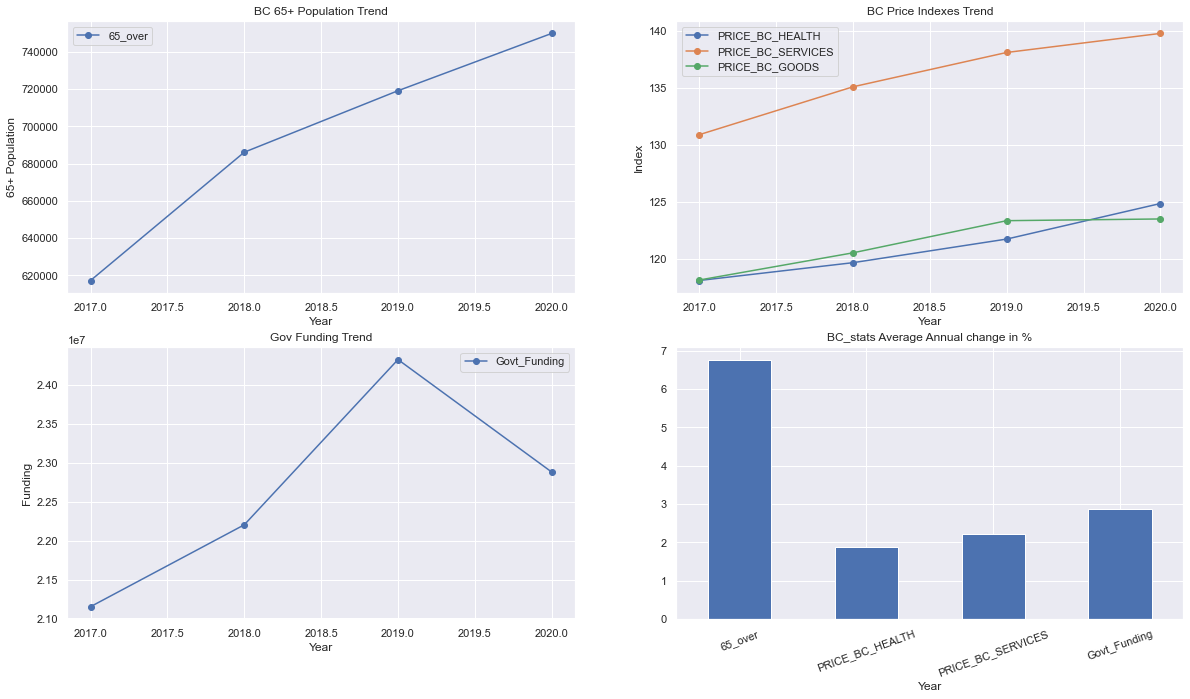

In [35]:
# dashboard with BC stats and Gov Funding trend

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(20,11))
ax1=seniors_Yr.set_index('Year').plot(marker='o',ax=ax1)
ax1.set_title('BC 65+ Population Trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('65+ Population')
ax2=BC_stats_Yr.plot(x='Year',marker='o',ax=ax2)
ax2.set_title('BC Price Indexes Trend')
ax2.set_xlabel('Year')
ax2.set_ylabel('Index')
ax3=Govfund_Yr.plot(x='Year',marker='o',ax=ax3)
ax3.set_title("Gov Funding Trend")
ax3.set_xlabel("Year")
ax3.set_ylabel("Funding")
ax4=df_cross1_Yr.plot(kind="bar",ax=ax4)
ax4.set_title("BC_stats Average Annual change in %")
ax4.set_xlabel("Year")
ax4.tick_params(axis='x', rotation=20);

Government Funding is growing at an average of 2.9% per year, which is not as high as elderly population, which is growing at an average of 6.8% per year. It may impact sooner or later operational expenses, and thus should be considered in the budget planning.

Although the average growth in Government funding appears to outpace the average growth in the health and service price indexes per year, the latter are on an ongoing positive trend, while Government funding has the growth in 2019 and the sharp fall in 2020. 


## 7.	Analysis of correlation between services growth & 65+ elderly population growth & government funding 

In this part we are going to find out the quantitative relationships between government funding, charitable expenditures (services volume) and growth of an aging population (older than 65). This should help to evaluate the approach to government funding and planning. 

### 7.1 Initial Exploration of Correlations 

In [36]:
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

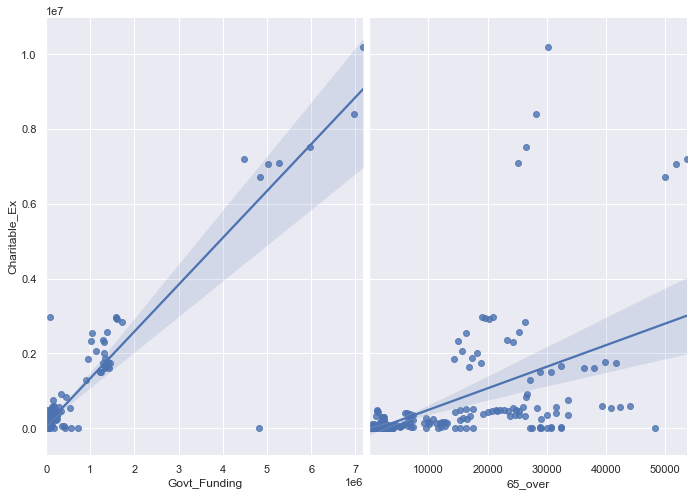

In [37]:
# Correlation between Charitable_Ex and Government funding&65+population at the BC level
sns.pairplot(df_4yrs, x_vars=['Govt_Funding','65_over'], y_vars='Charitable_Ex', height=7, aspect=0.7,diag_kind=None, kind='reg')

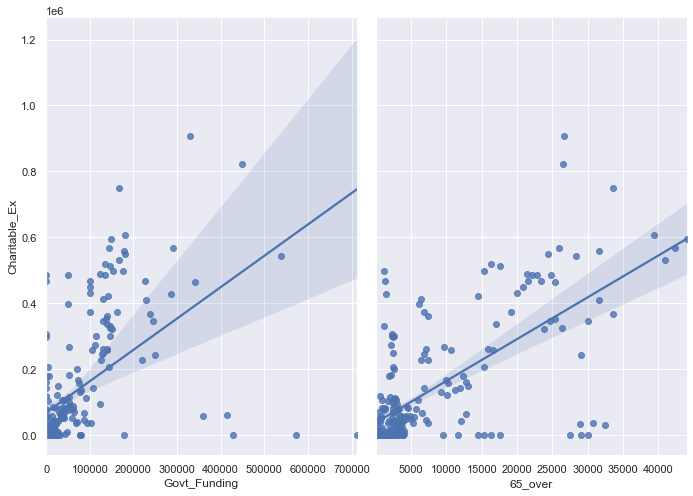

In [38]:
# Community hospices serve the majority of BC's 65+population
# So, let's look at the correlation between Charitable_Ex and Government funding&65+population at the community level
sns.pairplot(df_com, x_vars=['Govt_Funding','65_over'], y_vars='Charitable_Ex', height=7, aspect=0.7,diag_kind=None, kind='reg')

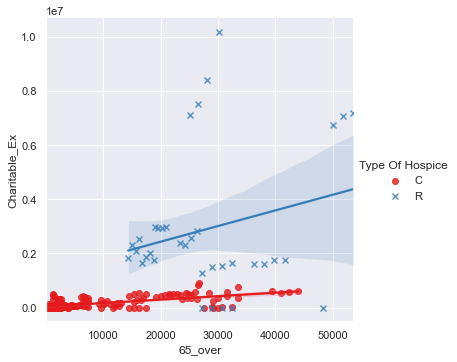

In [39]:
# Correlation between Charitable_Ex and 65+population by type of hospice
sns.lmplot(x="65_over", y="Charitable_Ex", hue="Type Of Hospice", data=df_4yrs,
           markers=["o", "x"], palette="Set1")

There is a strong correlation between services expenses and government funding at the BC level, while these variables are less correlated at the community level. 
The picture is opposite, with a correlation between services expenses and 65+population. Population over 65 show weaker linear correlation with services expenses at the BC level due to correlation impact of Residential hospices. Community hospices show stronger correlation between services expenses and 65+population. 

### 7.2 Quantitative Relationships and Expenses Prediction

<AxesSubplot:>

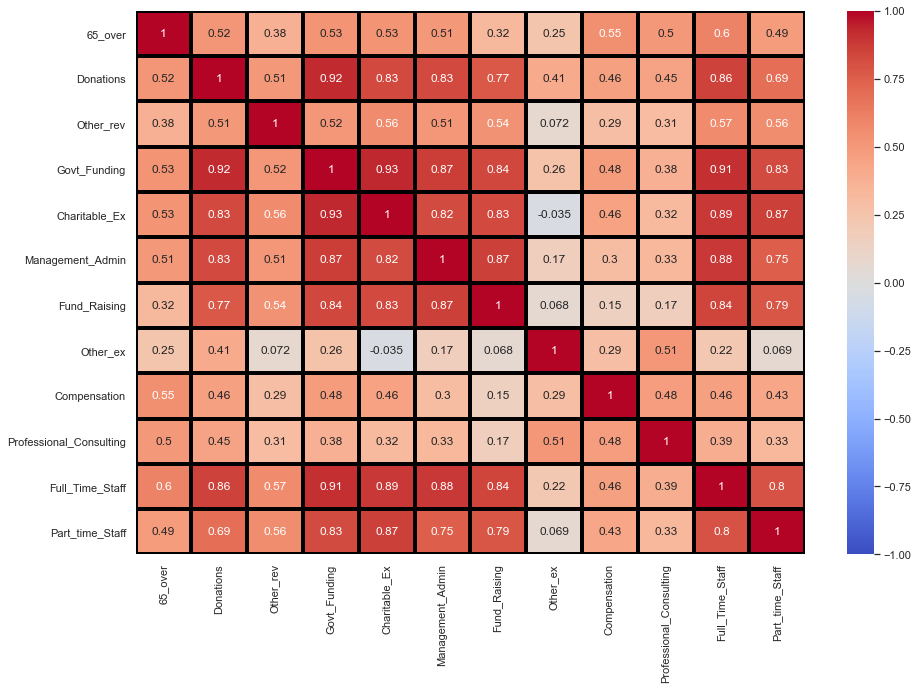

In [40]:
#The correlation matrix at the BC level
df_hmap_bc=df_4yrs[['65_over','Donations','Other_rev','Govt_Funding','Charitable_Ex','Management_Admin','Fund_Raising','Other_ex','Compensation','Professional_Consulting','Full_Time_Staff','Part_time_Staff']]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_hmap_bc.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black',ax=ax)

<AxesSubplot:>

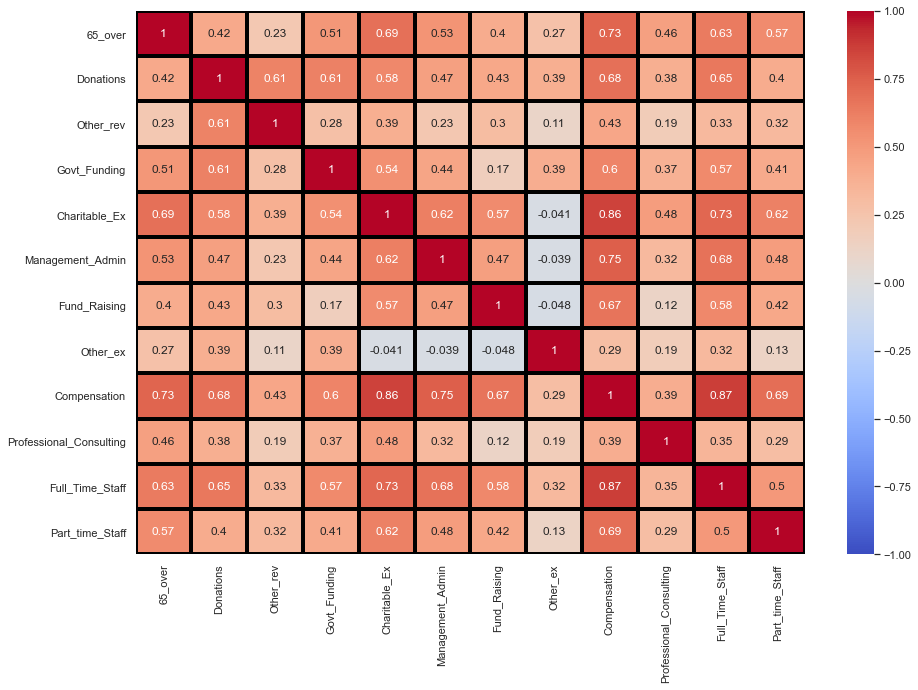

In [41]:
# The correlation matrix at the community level
df_hmap_com=df_com[['65_over','Donations','Other_rev','Govt_Funding','Charitable_Ex','Management_Admin','Fund_Raising','Other_ex','Compensation','Professional_Consulting','Full_Time_Staff','Part_time_Staff']]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_hmap_com.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black',ax=ax)

<AxesSubplot:>

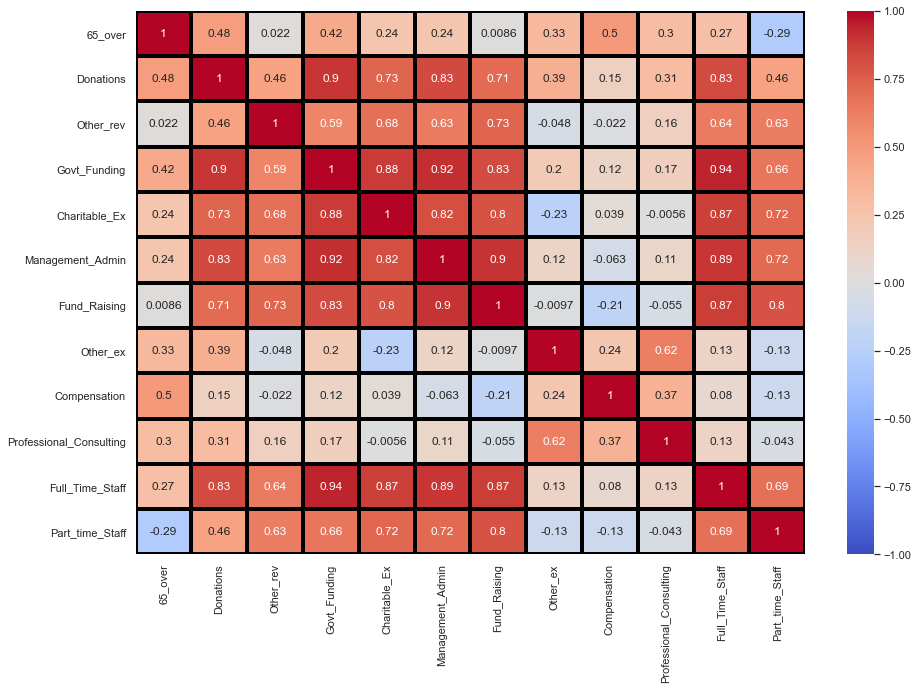

In [42]:
# The correlation matrix at the Residential hospices level
df_hmap_res=df_res[['65_over','Donations','Other_rev','Govt_Funding','Charitable_Ex','Management_Admin','Fund_Raising','Other_ex','Compensation','Professional_Consulting','Full_Time_Staff','Part_time_Staff']]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(df_hmap_res.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black',ax=ax)

Heatmaps approved the results shown on regplots. The correlation between Services expenses and government funding is 0.88 at the Residential hospices level and 0.54 at the community one. The correlation between Services expenses and 65+population is 0.24 at the Residential hospices level and 0.7 at the community one. In general, services expenses are positively correlated with all revenue and expenditure variables, which is logical. In the composition of expenses, the highest correlation with expenses for services are Compensation (salaries) and Management&Administration.

Community hospices cannot rely on government funding as correlation analysis shows less support for services expenses compared to residential ones. At the same time their expenses are linked to 65+population more strongly than in residential hospices. Therefore, it can be feasible to plan government funding for the community hospices depending on 65+population they serve.   

Next, we will try to determine quantitative relationship in linear regression models for community hospices:

 Charitable_Ex=Intercept+𝛽1*population over 65
 
The results can help plan government funds for community hospices.  

In [43]:
### STATSMODELS ###

# for statsmodel' _ 'should be removed from the name of 65_over
df_com=df_com.rename(columns={'65_over':'Seniors'})

# create a fitted statsmodel
lm = smf.ols(formula='Charitable_Ex ~ Seniors', data=df_com).fit()

# print the coefficients
lm.params

Intercept    38395.697558
Seniors         12.673468
dtype: float64

Evaluation of the stats model
1) calculating 95% confidence intervals for our model coefficients, which are interpreted as follows:
If the population from which this sample was drawn was sampled 100 times, approximately 95 of those confidence intervals would contain the "true" coefficient.

In [44]:
lm.conf_int()

,0,1
Intercept,17412.037478,59379.357638
Seniors,10.957552,14.389385


2) Hypothesis testing and p-value:

Null hypothesis: There is no relationship between Charitable_Ex and Seniors (and thus 𝛽1 equals zero)

Alternative hypothesis: There is a relationship between Charitable_Ex and Seniors (and thus 𝛽1 is not equal to zero)

the p-value represents the probability that the coefficient is actually zero

In [45]:
lm.pvalues

Intercept    3.808593e-04
Seniors      1.059089e-34
dtype: float64

If the 95% confidence interval includes zero, the p-value for that coefficient will be greater than 0.05. 

If the 95% confidence interval does not include zero, the p-value will be less than 0.05.

In this case, the p-value for Seniors is far less than 0.05, and so we believe that there is a relationship between Seniors and Charitable_Ex

3) R-squared is between 0 and 1, and higher is better because it means that more variance is explained by the model.

In [46]:
lm.rsquared

0.47181936112734746

Evaluation metrics confirm that relationships between Services expenses and 65+population are statistically significant. They also show that the expenses have high amount of unexplainable variability, and this property makes accurate prediction for the next years impossible.

We will try to extend simple linear regression to include additional feature, 'Compensation', which is highly correlated to expenses, includes all salaries paid and reflects the volume of services in the same way as Charitable expenses.  

In [47]:
### SCIKIT-LEARN ###

cols = ['Seniors','Compensation']
X = df_com[cols]
y = df_com['Charitable_Ex']
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2)
regr_model = LinearRegression()
estimator = regr_model.fit(train_X, train_y) # Fitting model to training data and saving in variable.
prediction = estimator.predict(test_X)
regr_model.coef_

array([2.7252158, 0.6634147])

In [48]:
# R-squared
print('Rsquared: {}\n'.format(metrics.explained_variance_score(test_y,prediction)))
# score the model on the train set
print('Train score: {}\n'.format(regr_model.score(train_X,train_y)))
# score the model on the test set
print('Test score: {}\n'.format(regr_model.score(test_X,test_y)))
# compute the mean squared error of the model
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(test_y,prediction)))) 

Rsquared: 0.8728384296687042

Train score: 0.6825080643494481

Test score: 0.8666365890623456

RMSE: 77786.45575105185


In [49]:
df_pred=pd.DataFrame({'Actual':test_y, 'Predicted':prediction})
df_pred.head(10)

,Actual,Predicted
82,497021,263391.999104
173,228027,171289.060583
181,550482,536439.203993
255,46182,57021.310537
330,15012,28272.239951
119,53674,52526.673005
21,1922,47830.680425
252,10872,32818.826331
159,322291,349156.320873
163,0,26935.475462


Metrics show good accuracy and mean error 93952, but the actual predictive power is low due to underfitting model.

Conclusions: 
1. 65+population dynamics do fuel expenses on services, especially in community hospices, but this indicator alone is not enough to explain and help predict future expenses.
2. Additional expenses influencers need to be defined, such as hours of operation, rates of terminal illness in health regions and communities, etc.
2. More records from previous years are needed to improve the predictive power of the model.

### Conclusions and recommendations 

1. Government funding is growing at 2.9% average in 4-year period with increase in 2019 and drop in 2020. Compared to other growth rates Services Expenses (16%), and 65+population (6.8%) over the same period it is obvious that government funding is lagging behind. Consequently, hospices have to double revenues coming from other sources to compensate and to ensure each hospice addresses the growing demand of its services. Thus, currently it would be recommended planning yearly funding increase linked to Health Care Price Index increase and senior population increase. 


2. The current financial model is not sustainable because increasing demand for services (services expenses) is mainly supported by increasing income from fundraising events and gifts from other charities. This is the only source of income with a stable growth trend, due to which the share of government funding and donations declined in 2019-2020. At the same time, the source is unstable and depends on external circumstances such as COVID. Indeed, the share of fundraising revenue was 65% in other revenue source until 2019 and dropped to 57% in 2020. Thus, it would be recommended to deploy social media platforms and explore ways to conduct fundraising events there. 


3. Ageing population growth fuels the services expenses increase; however, this growth alone cannot explain the difference in the amount spent by different hospices. There should be additional influencing indicators such as types of services provided and terminal illness statistics in different health regions or even at the community level. Thus, if there will be need in forecasting services expenses for the next years it is recommended conducting surveys to find out these indicators. Hospices organizations can report the services they provide in numbers (for each service hours, staff, supplies), and experts from a medical field can provide the statistics for predominant terminal illness in health regions and communities. 
 
 
4. After exploring the financial data, it was assumed that hospice organizations have relationships with each other and, for example, share fundraising and donations revenue. If it is true situation, it would be recommended exploring the hospices network to identify the relationships and gifts directions. Revealed financial relationships may be useful for budget and funding planning. It may be possible, as well, to determine hospice organizations that are center for smaller ones and can take a role in finance management. 